<h1>TKN Training Notebook</h1>
This notebook is used to train the network

In [1]:
import numpy as np
import pandas as pd
import os, datetime
import time
import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

import models

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.5.0-dev20201027
Num GPUs Available:  1


<h2>Data Processing</h2>

In [2]:
data_path = '~/data/E346E3B1E2881FAC.csv'

#TODO: get data and read more data
# df = pd.read_csv(data_path, delimiter=',', usecols=['DATE', 'TIME_M', 'BID', 'BIDSIZ', 'ASK', 'ASKSIZ', 'SYM_ROOT'],skiprows=[i for i in range(1,200000)], nrows=1000000)
df = pd.read_csv(data_path, delimiter=',', usecols=['date','PRC','VOL'],skiprows=[])

# Replace 0 to avoid dividing by 0 later on
# TODO: SHOULD USE FFILL, but doesn't work if first entry is 0
# or IDEALLY, USE SOME METHOD TO INDICATE VOLUME IS 0
df['VOL'].replace(to_replace=0, method='ffill', inplace=True)
df['PRC'].replace(to_replace=0, method='ffill', inplace=True)
df.sort_values(by=['date'], inplace=True)

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
#TODO: remove rolling mean
df[['PRC', 'VOL']] = df[['PRC', 'VOL']].rolling(10).mean() 

In [3]:
df.head()

,date,PRC,VOL
0,20180102,NaN,NaN
1,20180103,NaN,NaN
2,20180104,NaN,NaN
3,20180105,NaN,NaN
4,20180108,271.638,79641152.0


In [4]:
df.tail()

,date,PRC,VOL
246,20181224,245.709998,200843691.0
247,20181226,243.929996,217637744.2
248,20181227,243.292000,211892660.0
249,20181228,243.408000,192102022.4
250,20181231,245.252000,169892769.8


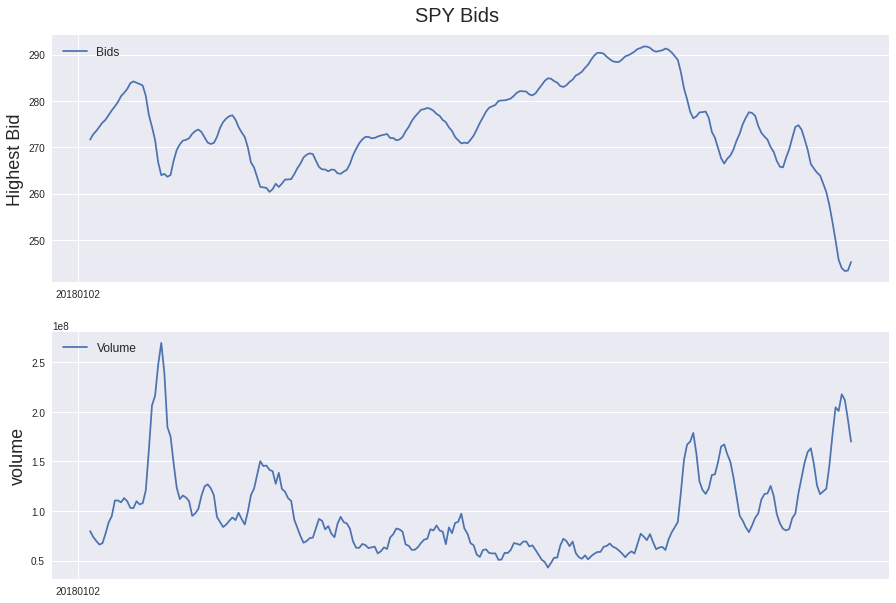

In [5]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("SPY Bids", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['PRC'], label='Bids')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['date'].loc[::1464])
ax1.set_ylabel('Highest Bid', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['VOL'], label='Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['date'].loc[::1464])
ax2.set_ylabel('volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

In [6]:
'''Calculate percentage change'''

df['PRC'] = df['PRC'].pct_change()
df['VOL'] = df['VOL'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values


# '''SCALE'''
# multiplier = 1024
# df['BID'] *= multiplier
# df['ASK'] *= multiplier
# df['BIDSIZ'] *= multiplier
# df['ASKSIZ'] *= multiplier

'''Normalize price columns'''

min_return = min(df['PRC'])
max_return = max(df['PRC'])

print(min_return)
print(max_return)

# Min-max normalize price columns (0-1 range)
df['PRC'] = (df['PRC'] - min_return) / (max_return - min_return)



'''Normalize volume column'''

min_volume = min(df['VOL'])
max_volume = max(df['VOL'])

# Min-max normalize volume columns (0-1 range)
df['VOL'] = (df['VOL'] - min_volume) / (max_volume - min_volume)

print((max_volume - min_volume))




'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date, time, symbol column
df_train.drop(columns=['date'], inplace=True)
df_val.drop(columns=['date'], inplace=True)
df_test.drop(columns=['date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.tail()

-0.017639339794956244
0.011666136387740167
0.5675056706217144
Training data shape: (197, 2)
Validation data shape: (25, 2)
Test data shape: (24, 2)


,PRC,VOL
197,0.315361,0.582988
198,0.275199,0.434000
199,0.429848,0.494460
200,0.655029,0.197990
201,0.706253,0.090120


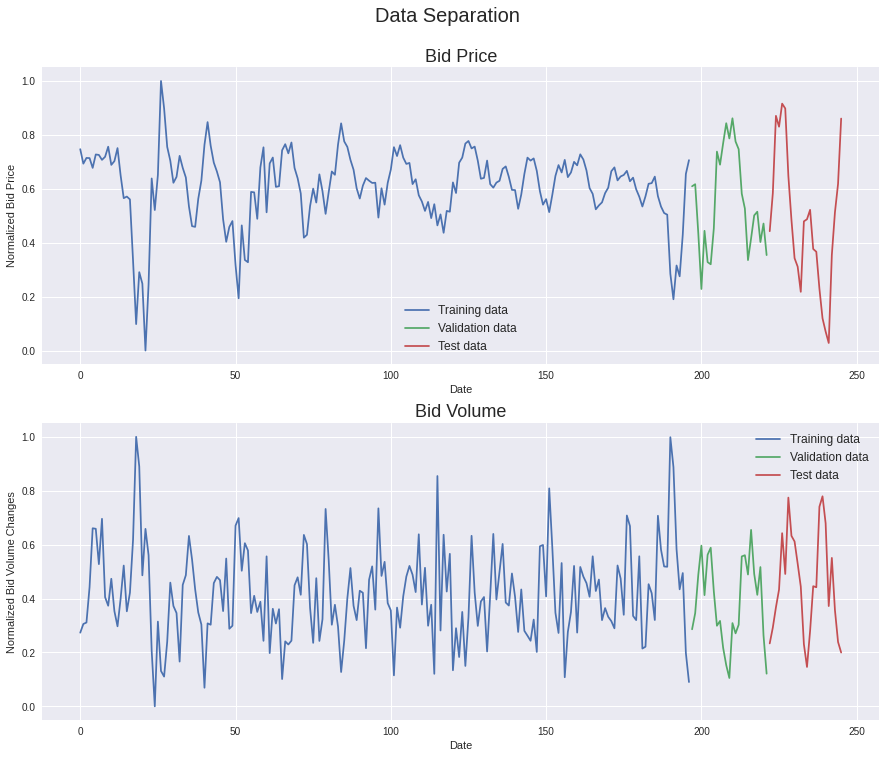

In [7]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['PRC'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['PRC'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['PRC'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Bid Price')
ax1.set_title("Bid Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['VOL'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['VOL'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['VOL'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Bid Volume Changes')
ax2.set_title("Bid Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

In [8]:
seq_len=20

# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append([train_data[i][0], train_data[i][1]]) #Value of col 0 and 2 (BID and ASK)
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append([val_data[i][0], val_data[i][1]])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append([test_data[i][0], test_data[i][1]])  
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (177, 20, 2) (177, 2)
Validation set shape (5, 20, 2) (5, 2)
Testing set shape (4, 20, 2) (4, 2)


<h2>Loss Function  and Optimizer</h2>

In [9]:
num_layers = 3
d_model = 16
dff = 128
num_heads = 16

dropout_rate = 0.01

In [10]:
#CUSTOM ADAM BASED ON https://arxiv.org/abs/1706.03762
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [11]:
learning_rate = CustomSchedule(d_model, warmup_steps=10)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [12]:
loss_object = tf.keras.losses.MeanSquaredError()

def loss_function(real, pred):
  loss_ = loss_object(real, pred)
  
  return tf.reduce_sum(loss_)

In [13]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [14]:
model = models.TKN_Basic(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, input_dim=2, output_dim=2,
              maximum_position_encoding=5000, rate=dropout_rate)

In [15]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(model=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

#if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [16]:
model.compile(optimizer, loss_function)
history = model.fit(X_train, y_train, 
                    batch_size=400, 
                    epochs=50, 
                    callbacks=[],
                    validation_data=(X_val, y_val))

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.8601 - val_loss: 0.7085
Epoch 2/50
1/1 [==============================] - 0s 39ms/step - loss: 0.7599 - val_loss: 10.2077
Epoch 3/50
1/1 [==============================] - 0s 35ms/step - loss: 10.1421 - val_loss: 0.2024
Epoch 4/50
1/1 [==============================] - 0s 36ms/step - loss: 0.2515 - val_loss: 6.9251
Epoch 5/50
1/1 [==============================] - 0s 37ms/step - loss: 6.6633 - val_loss: 0.8390
Epoch 6/50
1/1 [==============================] - 0s 42ms/step - loss: 0.9984 - val_loss: 2.5517
Epoch 7/50
1/1 [==============================] - 0s 39ms/step - loss: 2.2304 - val_loss: 1.9985
Epoch 8/50
1/1 [==============================] - 0s 37ms/step - loss: 1.8051 - val_loss: 13.3015
Epoch 9/50
1/1 [==============================] - 0s 42ms/step - loss: 13.1060 - val_loss: 7.8242
Epoch 10/50
1/1 [==============================] - 0s 35ms/step - loss: 7.2381 - val_loss: 6.0416
Epoch 11/50
1/1 [==========

In [17]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

In [18]:
#ckpt_manager.save()

In [19]:
train_pred

array([[0.6338458 , 0.4610818 ],
       [0.6338458 , 0.46108186],
       [0.6338458 , 0.46108183],
       [0.6338458 , 0.4610818 ],
       [0.6338458 , 0.46108186],
       [0.63384587, 0.4610819 ],
       [0.63384587, 0.46108192],
       [0.6338458 , 0.4610819 ],
       [0.6338458 , 0.4610819 ],
       [0.6338458 , 0.4610818 ],
       [0.6338459 , 0.46108183],
       [0.6338458 , 0.46108186],
       [0.63384575, 0.4610818 ],
       [0.6338458 , 0.46108186],
       [0.6338459 , 0.46108186],
       [0.6338458 , 0.46108183],
       [0.6338458 , 0.46108183],
       [0.6338459 , 0.4610818 ],
       [0.63384575, 0.4610818 ],
       [0.6338458 , 0.46108177],
       [0.6338458 , 0.4610818 ],
       [0.6338458 , 0.46108183],
       [0.63384587, 0.46108192],
       [0.6338459 , 0.46108186],
       [0.6338458 , 0.4610818 ],
       [0.6338458 , 0.4610818 ],
       [0.6338458 , 0.46108186],
       [0.63384587, 0.46108183],
       [0.6338458 , 0.4610819 ],
       [0.6338458 , 0.46108186],
       [0.

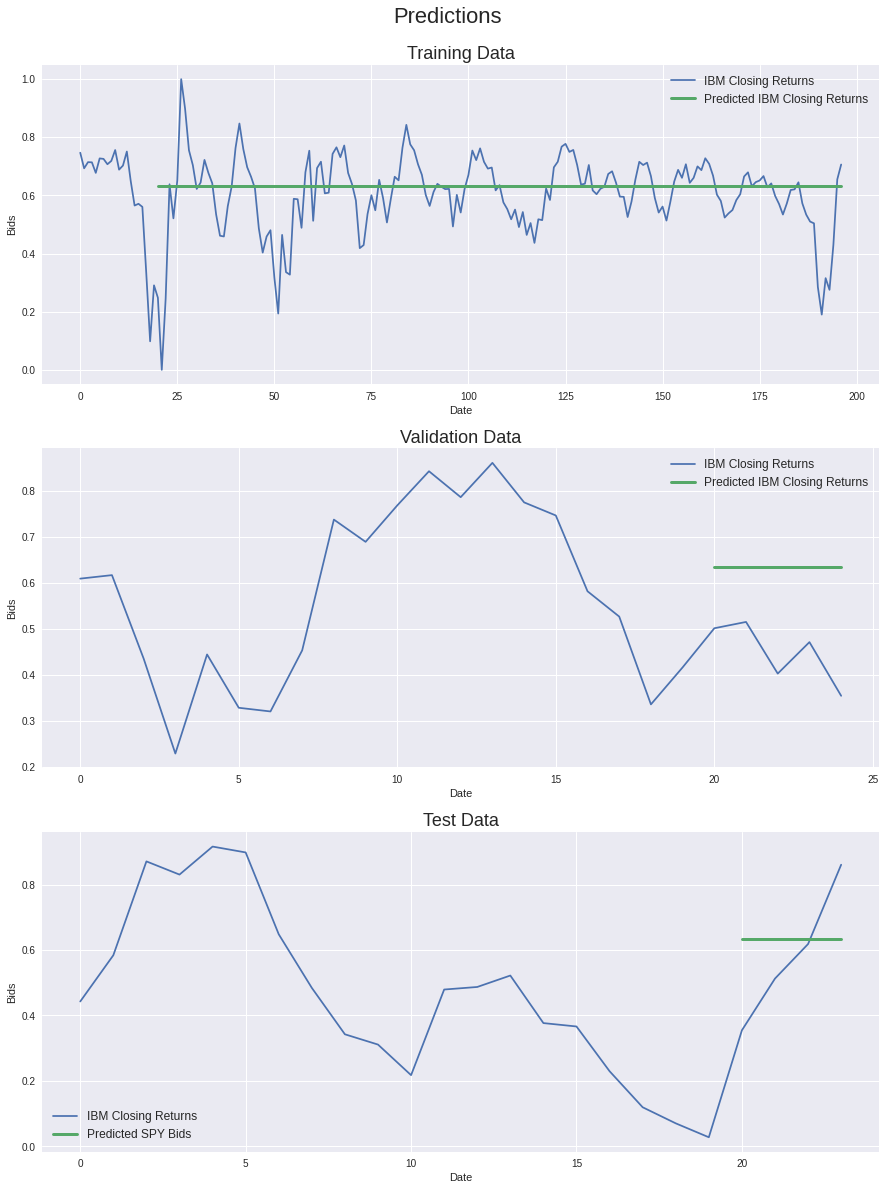

In [20]:
###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Predictions", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 0], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred[:,0], linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Bids')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 0], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred[:,0], linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Bids')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 0], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred[:,0], linewidth=3, label='Predicted SPY Bids')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Bids')
ax31.legend(loc="best", fontsize=12)
